# Open Jackson Network

The model illustrates:

* How to represent arrival rates in a network as a system of linear equations in matrix form
* How to use `scipy.linalg` functions to solve for the arrival rates
* How to upload parameters for your own network
* How to analyse the network

## Imports

In [1]:
# import piplite
# await piplite.install('scipy')
# await piplite.install('seaborn')

import scipy.linalg as linalg
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set()

## The example queueing network

**Question**: What is the expected number of customers in the entire queuing system?


<img src="image/jn_example.png" width="500">

## Step 1: Solve for $\lambda_i$

Given:

\begin{equation}
        \lambda_j = a_j + \sum_{i=1}^m \lambda_i p_{ij}
    \end{equation}
    
---

Plug the $a_j$ and $p_{ij}$ figures into the equation for $\lambda_j$ 

$$\lambda_1 = 1 + 0.1\lambda_2 + 0.4\lambda_3 $$
$$\lambda_2 = 4 + 0.6\lambda_1 + 0.4\lambda_3 $$
$$\lambda_3 = 3 + 0.3\lambda_1 + 0.3\lambda_2 $$

---
(optional) rearrange the equations with $a_j$ on the RHS

$$\lambda_1 - 0.1\lambda_2 - 0.4\lambda_3 = 1$$
$$-0.6\lambda_1 + \lambda_2 - 0.4\lambda_3 = 4$$
$$-0.3\lambda_1 - 0.3\lambda_2 + \lambda_3 = 3$$

---

Express the system of equations describing arrival rates in matrix form.

$$ \begin{bmatrix} 1 & -0.1 & -0.4\\ -0.6 & 1 & -0.4 \\ -0.3 & -0.3 & 1 \end{bmatrix} \begin{bmatrix} \lambda_1 \\ \lambda_2 \\ \lambda_3 \end{bmatrix}= \begin{bmatrix} 1\\ 4\\ 3 \end{bmatrix}$$

In [2]:
# create the matricies as numpy arrays
a = np.array([[1, -0.1, -0.4], [-0.6, 1, -0.4], [-0.3, -0.3, 1]])
b = np.array([1, 4, 3])

In [3]:
a

array([[ 1. , -0.1, -0.4],
       [-0.6,  1. , -0.4],
       [-0.3, -0.3,  1. ]])

In [4]:
b

array([1, 4, 3])

## Solve for the unknowns

To solve for the unknowns we need to take the dot product of the inverse of a and b

$$\begin{bmatrix} \lambda_1 \\ \lambda_2 \\ \lambda_3 \end{bmatrix} = \begin{bmatrix} 1 & -0.1 & -0.4\\ -0.6 & 1 & -0.4 \\ -0.3 & -0.3 & 1 \end{bmatrix}^{-1} \begin{bmatrix} 1\\ 4\\ 3 \end{bmatrix}$$

In [5]:
np.dot(linalg.inv(a), b)

array([ 5. , 10. ,  7.5])

An alternative way to solve for the unknowns is to use linalg.solve

In [6]:
arrival_rate = linalg.solve(a, b)
arrival_rate

array([ 5. , 10. ,  7.5])

## Step 2: Calculate the traffic intensity

$\rho_i = \dfrac{\lambda_i} {s_i \mu_i}$

Remember that you are treating each queuing system as an independent M/M/s

* Facility 1 is a M/M/1
* Facility 2 is a M/M/2
* Facility 3 is a M/M/1

#### Example solution

In [7]:
servers = np.array([1, 2, 1])
service_rate = np.array([10, 10, 10])

rho = arrival_rate / (servers * service_rate)
rho

array([0.5 , 0.5 , 0.75])

## Step 3: Calculate the number of people in the queue

For an M/M/1

$L_s = \dfrac{\rho}{1 - \rho}$

and for an M/M/s

$p_0 = \left[ \sum_{n=0}^{s-1} \frac{\left(\lambda/ \mu \right)^n}{n!} + \frac{\left( \lambda / \mu \right)^s}{s!\left(1-\rho\right)}  \right]^{-1}$

$L_q = \dfrac{p_o(\lambda/\mu)^s\rho}{s!(1-\rho)^2}$



$L_s = L_q + \dfrac{\lambda}{\mu}$


In [8]:
class MMSQueue:
    '''
    M/M/S/inf/inf/FIFO system
    '''
    def __init__(self, _lambda, mu, s):
        '''
        Constructor
        
        Parameters:
        -------
        _lambda: float
            The arrival rate of customers to the facility
            
        mu: float
            The service rate of the facility
            
        s: int
            The number of servers
        '''
        self._lambda = _lambda
        self.mu = mu
        self.s = int(s)
        self.rho = self._get_traffic_intensity()
        
        #create a dict of performance metrics
        #solve for L_q then use little's law to calculate remaining KPIs
        self.metrics = {}
        self.metrics[r'$\rho$'] = self.rho
        self.metrics[r'$L_q$'] = self._get_mean_queue_length()
        self.metrics[r'$L_s$'] = self.metrics[r'$L_q$'] + (_lambda / mu)
        self.metrics[r'$W_s$'] = self.metrics[r'$L_s$'] / _lambda
        self.metrics[r'$W_q$'] = self.metrics[r'$W_s$'] - (1 / mu)
        
    @property
    def total_in_system(self):
        return self.metrics[r'$L_s$']
        
    def _get_traffic_intensity(self):
        '''
        calculate the traffic intensity (server utilisation)
        of an M/M/s queue
        '''
        return self._lambda / (self.s * self.mu)  
    
    def _get_mean_queue_length(self):
        '''
        Mean length of queue Lq
        '''
        p0 = self.prob_system_empty()
       
        lq = (p0 * ((self._lambda / self.mu)**self.s) * 
              self.rho) / (math.factorial(self.s) * (1 - self.rho)**2)
        return lq
        
    def prob_system_empty(self):
        '''
        The probability that a M/M/s/infinity queue is empty
        '''
        p0 = 0.0

        for n in range(self.s):
            p0 += ((self._lambda / self.mu) ** n) / math.factorial(n)

        p0 += ((self._lambda / self.mu) ** self.s) / (math.factorial(self.s) 
                                                      * (1 - self.rho))
        return p0**-1
    
    def prob_n_in_system(self, n, return_all_solutions=True, as_frame=True):
        '''
        Calculate the probability that n customers
        in the system (queuing + service)

        Parameters:
        --------
        n: int,
            Number of customers in the system

        return_all_solutions: bool, optional (default=True)
            Returns all solutions for 0,1 ... n
            
        as_frame: bool, optional (default=True)
            If True, returns all solutions in a pd.DataFrame
            else returns all solutions as np.ndarray
            has no effect is return_all_solutions == False

        Returns:
        ------
            np.ndarray of solutions

        '''
        p0 = self.prob_system_empty()
        probs = [p0]

        #for n <= s
        for i in range(1, min(self.s+1, n+1)):
            pn = (((self._lambda / self.mu)**i) / math.factorial(i)) * p0
            probs.append(pn)

        #for n > s
        for i in range(self.s+1, n+1):
            pn = (((self._lambda / self.mu)**i) / (math.factorial(self.s) 
                                                   * (self.s**(n-self.s)))) * p0
            probs.append(pn)

        if return_all_solutions:
            results = np.array(probs)
            if as_frame:
                return pd.DataFrame(results, columns=['P(X=n)'])
            else:
                return results
        else:
            return probs[:-1]
        
    def summary_frame(self):
        '''
        Return performance metrics
        
        Returns:
        ---------
        pd.DataFrame
        '''
        df = pd.Series(self.metrics).to_frame()
        df.columns = ['performance']
        return df

In [9]:
queues = [MMSQueue(l, mu, s) for l, mu, s in zip(arrival_rate, service_rate, 
                                                 servers)]

queues[0].summary_frame()

,performance
$\rho$,0.5
$L_q$,0.5
$L_s$,1.0
$W_s$,0.2
$W_q$,0.1


In [10]:
queues[1].summary_frame().round(2)

,performance
$\rho$,0.50
$L_q$,0.33
$L_s$,1.33
$W_s$,0.13
$W_q$,0.03


In [11]:
queues[2].summary_frame()

,performance
$\rho$,0.75
$L_q$,2.25
$L_s$,3.00
$W_s$,0.40
$W_q$,0.30


#### Example solution

In [12]:
# total in system
total_in_system = sum([q.total_in_system for q in queues])
print(f'Expected # of customers in queuing network = {total_in_system:.2f}')

Expected # of customers in queuing network = 5.33


## Convenience class for Network problem

In [13]:
class JacksonNetwork:
    '''
    Open Jackson Queuing Network
    
    A simple implementation where a system of linear equations is specified in
    matrix form by a user as opposed to manually adding nodes.
    
    Create and conveniently holds a collection of MMSQueues.
    '''
    def __init__(self, a, b, service_times, servers):
        '''
        Init the network
        
        Params:
        ------
        a: np.ndarray
            routing of entities through network 
            Note this rearranged for calculation.
            
        b: np.ndarray
            arrival rates to nodes from outside the network
            
        service_times: np.ndarray
            Service rate at each node
            
        servers: np.ndarray
            No. of servers at each node
                
        '''
        self.a = a
        self.b = b
        self.service_times = service_times
        self.servers = servers
        
        # number of queues
        self.n_nodes = len(service_times)
        
        # solve for arrival rates
        self.arrival_rate = linalg.solve(a, b)
        
        # create MMS queues
        self.queues = self._create_mms_queues()
           
    @property
    def total_in_system(self):
        '''
        The expected number of entities in the jackson network
        Sum of expected number of entities in each MMSQueue
        
        Returns:
        -------
        float
        '''
        return sum([q.total_in_system for q in queues])
    
    def summary_frame(self):
        '''
        Tabular summary the performance measures in each queuing node
        
        For each node returns Rho, L_q, L_s, W_q, W_s, 
        
        Returns:
        --------
        pd.DataFrame
        '''
        summary = pd.DataFrame()
        
        for node_id, q in zip(range(len(self.queues)), self.queues):
            node_summary = q.summary_frame()
            node_summary.columns = ['node_' + str(node_id)]
            summary = pd.concat([summary, node_summary], axis=1)
        
        return summary
        
    
    def _create_mms_queues(self):
        '''
        Create and parameterise the required number of MMSQueue objects
        
        Returns:
        --------
        List
        
        '''
        return [MMSQueue(l, mu, s) for l, mu, s in zip(self.arrival_rate, 
                                                       self.service_times, 
                                                       self.servers)]
    

In [14]:
model = JacksonNetwork(a, b, service_rate, servers)
summary = model.summary_frame().round(2)
summary

,node_0,node_1,node_2
$\rho$,0.5,0.50,0.75
$L_q$,0.5,0.33,2.25
$L_s$,1.0,1.33,3.00
$W_s$,0.2,0.13,0.40
$W_q$,0.1,0.03,0.30


In [15]:
print(f'Expected # of customers in queuing network = {model.total_in_system:.2f}')

Expected # of customers in queuing network = 5.33


<Figure size 864x432 with 0 Axes>

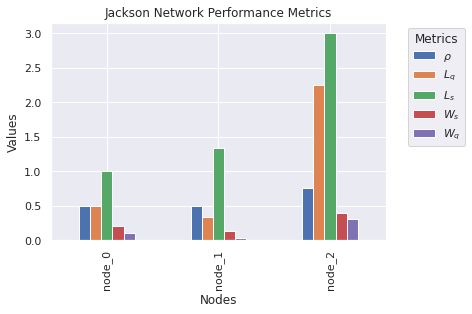

In [16]:
def plot_jackson_network_summary(summary):
    plt.figure(figsize=(12,6))
    summary.T.plot(kind='bar')
    plt.title('Jackson Network Performance Metrics')
    plt.xlabel('Nodes')
    plt.ylabel('Values')
    plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
plot_jackson_network_summary(summary)

In [47]:

class JacksonNetworkExtData:
    """
    Open Jackson Queuing Network model.
    
    This class models a network of M/M/S queues and computes key performance 
    metrics for each node in the network.
    
    Parameters are read from a csv file
    """
    def __init__(self, arrival_matrix, external_arrival, service_rates, servers):
        """
        Initialize the Jackson Network model.
        
        Parameters:
        -----------
        arrival_matrix : np.ndarray
            Routing matrix of entities through the network.
        external_arrival : np.ndarray
            External arrival rates to each node from outside the network.
        service_rates : np.ndarray
            Service rate at each node.
        servers : np.ndarray
            Number of servers at each node.
        """
        self.arrival_matrix = self.rearrange_matrix(arrival_matrix)
        self.external_arrival = external_arrival
        self.service_rates = service_rates
        self.servers = servers

        # Solve for arrival rates at each node (lambda values)
        self.arrival_rate = linalg.solve(self.arrival_matrix, external_arrival)

        # Create MMS queues for each node
        self.queues = [MMSQueue(l, mu, s) for l, mu, s in zip(self.arrival_rate, service_rates, servers)]

    def rearrange_matrix(self, routing_matrix):
        """
        Rearranges the routing matrix to express the system of equations in the required form.
        
        Converts the routing matrix P into a matrix A where:
        - A_{ii} = 1 (diagonal elements)
        - A_{ij} = -P_{ij} (off-diagonal elements)
        
        Parameters:
        -----------
        routing_matrix : np.ndarray
            Original routing matrix P.
        
        Returns:
        --------
        np.ndarray
            Transformed matrix A.
        """
        n = routing_matrix.shape[0]
        # Initialize the matrix A with identity matrix (diagonal elements = 1)
        A = np.eye(n)
        
        # Fill off-diagonal elements with -P_ij values
        for i in range(n):
            for j in range(n):
                if i != j:
                    A[i, j] = -routing_matrix[i, j]
        
        return A

    def summary_frame(self):
        """
        Generate a summary DataFrame of performance metrics for each node.
        
        Returns:
        --------
        pd.DataFrame
            A DataFrame containing the performance metrics for all nodes.
        """
        summary = pd.DataFrame()
        for i, queue in enumerate(self.queues):
            node_summary = queue.summary_frame()
            node_summary.columns = [f'node_{i + 1}']
            summary = pd.concat([summary, node_summary], axis=1)
        return summary

    def total_in_system(self):
        """
        Calculate the total number of entities in the network.
        
        Returns:
        --------
        float
            Total expected number of customers in the network.
        """
        return sum(queue.metrics[r'$L_s$'] for queue in self.queues)

def read_params_from_csv(file_path):
    """
    Read Jackson Network parameters from a CSV file, ignoring the first column.
    
    Parameters:
    -----------
    file_path : str
        The path to the CSV file.
    
    Returns:
    --------
    np.ndarray
        Arrival matrix (routing matrix).
    np.ndarray
        Service rates for each node.
    np.ndarray
        Number of servers for each node.
    np.ndarray
        External arrival rates.
    """
    df = pd.read_csv(file_path)

    arrival_matrix = df.iloc[:-1, 1:-2].values  
    service_rates = df['service_rate'][:-1].values  
    servers = df['servers'][:-1].values  
    external_arrival = df.iloc[-1, 1:-2].values.astype(float) 

    return arrival_matrix, service_rates, servers, external_arrival

def run_jackson_network(file_path):
    """
    Read parameters from a CSV, create a Jackson Network, and output metrics.
    
    Parameters:
    -----------
    file_path : str
        The path to the CSV file containing the network parameters.
    
    Returns:
    --------
    None
    """
    arrival_matrix, service_rates, servers, external_arrival = read_params_from_csv(file_path)

    # Create Jackson Network model
    model = JacksonNetworkExtData(arrival_matrix, external_arrival, service_rates, servers)

    # Display summary table
    summary = model.summary_frame().round(2)
    
    # Plot the performance metrics
    plot_jackson_network_summary(summary)
    
    # Access the rearranged matrix from the model and return it
    rearranged_matrix = model.arrival_matrix  # The rearranged matrix inside the model
    
    # Print the matrices and arrival rates for checking
    print("\nOriginal Arrival Matrix from CSV:")
    print(arrival_matrix)
    
    print("\nRearranged Matrix (used in calculation):")
    print(rearranged_matrix)
    
    print("\nSolved Arrival Rates:")
    print(model.arrival_rate)
    
    print('..........................................')
    
    return(summary)


def plot_jackson_network_summary(summary):
    """
    Plot the Jackson Network performance metrics.
    
    Parameters:
    -----------
    summary : pd.DataFrame
        The summary DataFrame of performance metrics for each node.
    
    Returns:
    --------
    None
    """
    summary.T.plot(kind='bar', figsize=(12, 6))
    plt.title('Jackson Network Performance Metrics')
    plt.xlabel('Nodes')
    plt.ylabel('Values')
    plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()




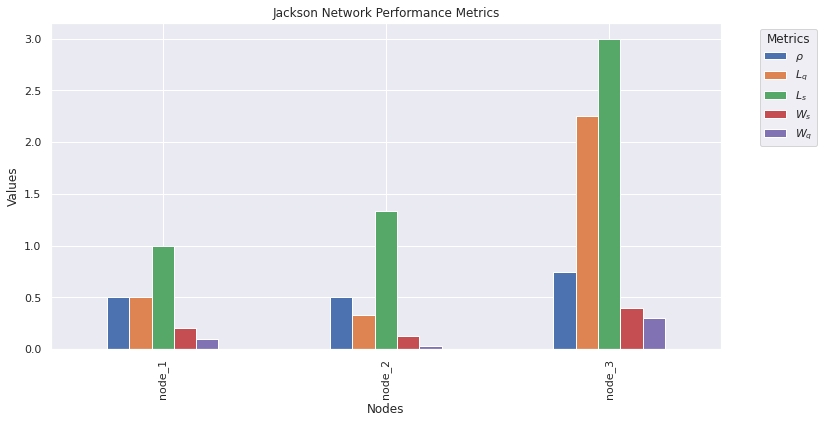


Original Arrival Matrix from CSV:
[[0.  0.1 0.4]
 [0.6 0.  0.4]
 [0.3 0.3 0. ]]

Rearranged Matrix (used in calculation):
[[ 1.  -0.1 -0.4]
 [-0.6  1.  -0.4]
 [-0.3 -0.3  1. ]]

Solved Arrival Rates:
[ 5.  10.   7.5]
..........................................


,node_1,node_2,node_3
$\rho$,0.5,0.50,0.75
$L_q$,0.5,0.33,2.25
$L_s$,1.0,1.33,3.00
$W_s$,0.2,0.13,0.40
$W_q$,0.1,0.03,0.30


In [57]:
filepath_test = '../data/test_parameters.csv'


# fun function from filepath   
run_jackson_network('../data/test_parameters.csv')

## Example use case

For a scenario involving a general surgical ward, an intensive care unit (ICU), and a high-dependency ward (HDW), `usecase_parameters.csv` provides example data for arrival rates, service rates, servers (resources), and routing probabilities.

This scenario models patients moving between these three departments after surgery, with different probabilities of being routed to each depending on their post-surgical needs.

SCENARIO OVERVIEW:

**Node 1: General Surgical Ward (GSW)**

Patients admitted here after routine surgeries.
Some patients may deteriorate and require transfer to the HDW or ICU for more intensive care.
Others recover and are discharged directly from this ward.

**Node 2: High-Dependency Ward (HDW)**

Intermediate care for patients who need close monitoring but do not require full ICU support.
After stabilizing, patients are either transferred back to the general ward or, if their conditions deteriorates, are moved to the ICU.

**Node 3: Intensive Care Unit (ICU)**

For the most critical patients who need intensive monitoring and life-supporting interventions.
After improvement, patients are transferred either to the HDW or back to the general ward.


### Example Data read from csv file:

**Arrival Rates: external arrivals directly to each ward**
General Surgical Ward (GSW): 12 patients per day.
High-Dependency Ward (HDW): 3 patients per day (direct admissions from other hospitals or emergency).
ICU: 1 patient per day (critical emergency cases).

**Service Rates (How fast each ward processes patients)**
General Surgical Ward (GSW): 5 patients per day.
High-Dependency Ward (HDW): 3 patients per day.
ICU: 2 patients per day (2 patients per day).

**Number of Servers (Resources)**
General Surgical Ward (GSW): 20 beds.
High-Dependency Ward (HDW): 10 beds.
ICU: 5 beds.

**Routing Probabilities**
These are the probabilities that a patient will be routed between departments or discharged based on their recovery progress:

*General Surgical Ward (GSW):*

70% chance of being discharged.
20% chance of being transferred to the High-Dependency Ward (HDW) due to complications.
10% chance of being transferred to the ICU in case of critical deterioration.

*High-Dependency Ward (HDW):*

50% chance of returning to the General Surgical Ward (GSW).
10% chance of deteriorating and being transferred to the ICU.
40% chance of being discharged after recovery.

*ICU:*

30% chance of being transferred to the High-Dependency Ward (HDW) for step-down care.
20% chance of being transferred directly to the General Surgical Ward (GSW).
50% chance of being discharged after stabilization.

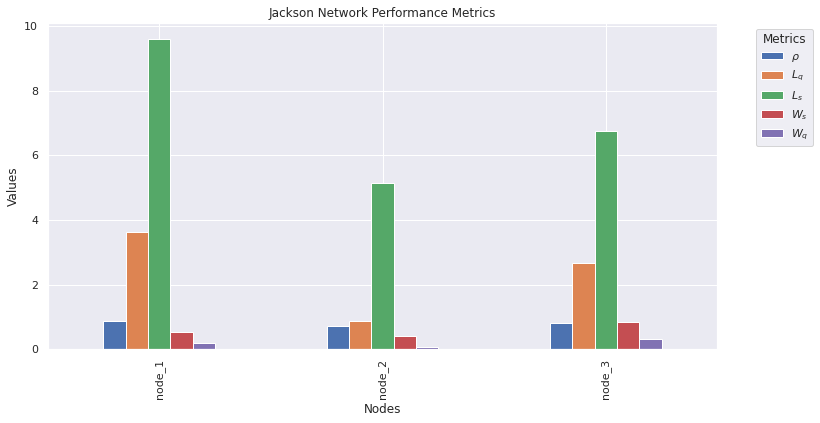


Original Arrival Matrix from CSV:
[[0.   0.2  0.05]
 [0.5  0.   0.1 ]
 [0.2  0.3  0.  ]]

Rearranged Matrix (used in calculation):
[[ 1.   -0.2  -0.05]
 [-0.5   1.   -0.1 ]
 [-0.2  -0.3   1.  ]]

Solved Arrival Rates:
[17.96994697 12.80347672  8.18503241]
..........................................


,node_1,node_2,node_3
$\rho$,0.86,0.71,0.82
$L_q$,3.62,0.87,2.66
$L_s$,9.61,5.14,6.75
$W_s$,0.53,0.40,0.83
$W_q$,0.20,0.07,0.33


In [68]:
filepath_usecase = '../data/usecase_parameters.csv'


# fun function from filepath   
run_jackson_network(filepath_usecase)

## Interpretation of metrics

System Stability: All nodes are operating within a steady state, with utilization below 1.0. Node 1 (General Surgical Ward) is the most heavily utilized, followed by Node 3 (ICU).

Queue Formation: Node 1 (Surgical ward) has the largest queue (3.62 patients on average), followed by Node 3 (ICU, 2.66 patients on average). Node 2 has minimal queuing and processes patients quickly.

Longer Stays in ICU: Patients in Node 3 (ICU) spend the most time in the system (20 hours). 

Waiting Times: Node 1 and Node 3 patients wait 4.8 hours in Node 1 and 8 hours in the ICU. Node 2 patients wait 1.68 hours on average.

### Recommendations:

Monitor ICU Performance: The ICU (Node 3) is stable, but with a utilization of 0.82 and a queue of 2.66 patients, the ICU may experience higher waiting times if patient load increases. It may be worth considering additional resources.

Manage Queue in Node 1: With a queue length of 3.62 patients and waiting times of 4.8 hours, Node 1 could benefit from optimizing its resource allocation or adjusting patient flow if possible.

Utilize Node 2 Capacity: Node 2 has the lowest utilization and the shortest waiting time, indicating it has room to handle more patients. Adjustments to patient routing could help relieve pressure on Nodes 3.